<!--NOTEBOOK_HEADER-->
*This notebook is adapted from course material from [CBE20255](https://jckantor.github.io/CBE20255)
by Jeffrey Kantor (jeff at nd.edu); the original content is available [on Github](https://github.com/jckantor/CBE20255.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Binary distillation with McCabe-Thiele method

## Problem Statement

*Adapted from Example 18.2, McCabe, Smith, and Harriott, "Unit Operations of Chemical Engineering," 5th ed., 1993.* 

A continuous fractionating column is to be designed to separate 30,000 kg/h of a mixture of 40% benzene and 60% toluene into an overhead product containing 97% benzene and a bottom product containing 98% toluene (by weight). A reflux ratio of 3.5 mol to 1 mol of product is to be used. The molal latent heats of benzene and toluene are 7,360 and 7,960 cal/g mol, respectively.  Benzene and toluene form an ideal system with a relative volatility of about 2.5. The feed has a boiling point of 95 &deg;C at a pressure of 1 atm. 

a) Calculate the moles of overhead product and bottom product per hour.

b) Determine the number of ideal plates and the position of the feed plate if the feed is liquid and at its boiling point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import exp as exp
from math import pow as pow
from math import floor as floor
from math import ceil as ceil
%matplotlib inline

## Production Rate

The molecular weight of benzene is 78 and that of toluene is 92.

In [2]:
mw = dict()
mw['benzene'] = 78
mw['toluene'] = 92 

Simple mass balance can be used to compute the feed, overhead, and bottoms in mole fraction of benzene ($x_F$, $x_D$, and $x_B$, respectively).

In [3]:
A = 'benzene'
B = 'toluene'

xF = (40/mw[A] / (40/mw[A] + 60/mw[B]))
xD = (97/mw[A] / (97/mw[A] +  3/mw[B]))
xB = ( 2/mw[A] / ( 2/mw[A] + 98/mw[B]))

### Saturation Pressure Data

The saturation (vapor) pressure of benzene and toluene can be computed by

\begin{align}
\ln \frac{P_{sat}}{P_c} &= \frac{Ax + Bx^{1.5} + Cx^3 + Dx^6}{1-x}\\
x &= 1-\frac{T}{T_c}
\end{align}

The constants for these equations come from Appendix A of Reid, Prausnitz, ane Poling with units of temperature in Kelvin and pressure in bar. 

We will store the functions in dictionaries where the key is an identifier for the chemical specie. This approach is overkill for this particular problem, but it may be useful in other situations involving multiple chemical species.

In [4]:
x_Psat = dict()
x_Psat['benzene'] = lambda T: 1 - T/562.2
x_Psat['toluene'] = lambda T: 1 - T/591.8

Psat = dict()
Psat['benzene'] = lambda T: 48.9 * exp(( -6.98273 * x_Psat['benzene'](T) +
                                         1.33213 * pow(x_Psat['benzene'](T), 3/2) +
                                         -2.62863 * pow(x_Psat['benzene'](T), 3) +
                                         -3.33399 * pow(x_Psat['benzene'](T), 6) )/ (1-x_Psat['benzene'](T)))
Psat['toluene'] = lambda T: 41.0 * exp(( -7.28607 * x_Psat['toluene'](T) +
                                         1.38091 * pow(x_Psat['toluene'](T), 3/2) +
                                         -2.83433 * pow(x_Psat['toluene'](T), 3) +
                                         -2.79168 * pow(x_Psat['toluene'](T), 6) )/ (1-x_Psat['toluene'](T)))

### Saturation Temperatures

We can solve the $P_{sat}$ equation for temperature to compute the saturation temperatures (boiling points) for benzene and toluene at the operating pressure (1 atm = 1.01325 bar). This will determine the lower and upper bound on temperatures for the equilibrium-line.

In [5]:
Tsat = dict()
for s in Psat.keys():
    Tsat[s] = lambda P, s=s: fsolve(lambda T: Psat[s](T)-P, 400)[0]

In [6]:
P = 1.01325 # pressure in bar

T_A = Tsat[A](P)
T_B = Tsat[B](P)

print("{:12s}  {:.1f} K".format(A, T_A))
print("{:12s}  {:.1f} K".format(B, T_B))

benzene       353.3 K
toluene       383.9 K


These values are very close to the actual boiling points for benzene and toluene of 353.2 K and 383.8 K, respectively.  

*Of course, since we are operating at 1 atm, we could have just looked these values up in the first place, but the above approach is necessary if we are operating at some other pressure!*

Now, we create an array of temperatures for our plots.

In [7]:
T = np.linspace(T_A, T_B)
help(np.linspace)

Help on function linspace in module numpy:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is excluded.  Note that the step
        size changes when `endpoint` is False.
    num : int, optional
        Number of samples to generate. Default is 50. Must be non-negative.
    endpoint : bool, optional
        If True, `stop` is


plt.figure(figsize=(10,6))

plt.plot([x(T) for T in T],T,[y(T) for T in T],T)
plt.xlabel('Mole Fraction n-heptane')
plt.ylabel('Temperature deg C')
plt.title('Txy diagram for n-heptane/n-hexane at 1520 mmHg')
plt.legend(['Bubble Point','Dew Point'])
plt.grid()

plt.ylim(120,155)
plt.xlim(0,1)
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(120,155,36));

Tdew = fsolve(lambda T: y(T)-0.60, 138)
ax = plt.axis()
plt.plot([0.6,0.6,x(Tdew)],[ax[2],Tdew,Tdew],'r-')
plt.plot(x(Tdew),Tdew,'ro',ms=10)
plt.text(0.6+0.05,Tdew,'Tdew = {:5.1f} deg C'.format(float(Tdew)))
plt.text(x(Tdew)-.1,Tdew-3,'x(Tdew) = {:5.3f}'.format(float(x(Tdew))))

#plt.savefig('Txy Diagram Soln.png')

## Equilibrium Diagram

For the McCabe-Thiele graphical method, we first need to plot the equilibrium diagram with the liquid mole fraction of benzene on the x-axis and the vapor mole fraction of toluene on the y-axis. We also add verticals at $x_D$, $x_F$, and $x_B$ from the x-axis to the diagonal of the diagram.

In [14]:
x = lambda T: (P-Psat[B](T))/(Psat[A](T)-Psat[B](T))
y = lambda T: x(T)*Psat[A](T)/P

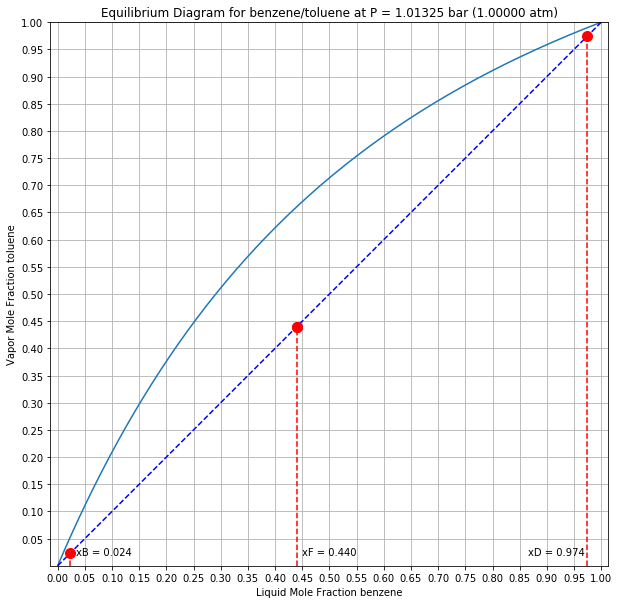

In [34]:
plt.figure(figsize=(10,10))
plt.plot([x(T) for T in T],[y(T) for T in T])

plt.plot([0,1],[0,1],'b--')
plt.axis('equal')
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(0.05,1.0,20))

plt.title('Equilibrium Diagram for {:s}/{:s} at P = {:.5f} bar ({:.5f} atm)'.format(A,B,P,P/1.01325))
plt.xlabel('Liquid Mole Fraction {:s}'.format(A))
plt.ylabel('Vapor Mole Fraction {:s}'.format(B))

plt.plot([xD,xD], [0,xD], 'r--')
plt.plot(xD,xD, 'ro', ms=10)
plt.text(xD-0.11, 0.02, 'xD = {:0.3f}'.format(float(xD)))

plt.plot([xF,xF], [0,xF], 'r--')
plt.plot([xF,xF], [xF,xF], 'ro', ms=10)
plt.text(xF+0.01, 0.02, 'xF = {:0.3f}'.format(float(xF)))

plt.plot([xB,xB], [0,xB], 'r--')
plt.plot(xB,xB, 'ro', ms=10)
plt.text(xB+0.01, 0.02, 'xB = {:0.3f}'.format(float(xB)))

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid();

## Feed line

The second step is to extend the feed line to the equilibrium curve. First, we calculate the intercept of the vertical feed line with the equilibrium curve.

In [27]:
Tbub = fsolve(lambda T:x(T) - xF, np.mean(T))
yF = y(Tbub)

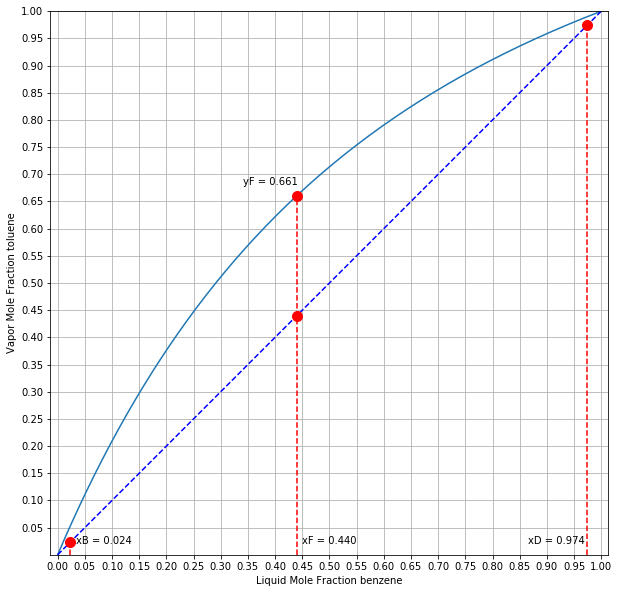

In [36]:
plt.figure(figsize=(10,10))
plt.plot([x(T) for T in T],[y(T) for T in T])

plt.plot([0,1],[0,1],'b--')
plt.axis('equal')
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(0.05,1.0,20))

plt.xlabel('Liquid Mole Fraction {:s}'.format(A))
plt.ylabel('Vapor Mole Fraction {:s}'.format(B))

plt.plot([xD,xD], [0,xD], 'r--')
plt.plot(xD,xD, 'ro', ms=10)
plt.text(xD-0.11, 0.02, 'xD = {:0.3f}'.format(float(xD)))

plt.plot([xF,xF,xF],[0,xF,yF],'r--')
plt.plot([xF,xF],[xF,yF],'ro',ms=10)
plt.text(xF+0.01,0.02,'xF = {:0.3f}'.format(float(xF)))
plt.text(xF-0.1,yF+0.02,'yF = {:0.3f}'.format(float(yF)));

plt.plot([xB,xB], [0,xB], 'r--')
plt.plot(xB,xB, 'ro', ms=10)
plt.text(xB+0.01, 0.02, 'xB = {:0.3f}'.format(float(xB)))

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid();

## Operating lines

Next, we plot the operating lines.  The operating line for the rectifying section is

\begin{equation}
y_{n+1} = \frac{R_D}{R_D+1} x_n + \frac{x_D}{R_D + 1}
\end{equation}

Therefore, the intercept of the rectifying line on the y-axis is given by $x_D/(R_D + 1)$, where $R_D$ is the reflux ratio (3.5 for our problem).  The y-value of the intercept of the rectifying line and the stripping line, $z_F$, at $x_F$ can then be calculated. 

In [48]:
R_D = 3.5
R_slope = R_D/(R_D+1)
R_intercept = xD/(R_D + 1)
print('Rectifying line intercept: {:0.3f}'.format(R_intercept))
zF = (R_D/(R_D+1))*xF + R_intercept
print('Rectifying and stripping line intercept: {:0.3f}'.format(zF))

Rectifying line intercept: 0.217
Rectifying and stripping line intercept: 0.559


The slope of the stripping line is:

\begin{equation}
S_{slope} = \frac{z_F-x_B}{x_F-x_B}
\end{equation}

In [49]:
S_slope = (zF-xB)/(xF-xB)
S = 1/(S_slope-1)
print('Stripping factor: {:0.3f}'.format(S))

Stripping factor: 3.510


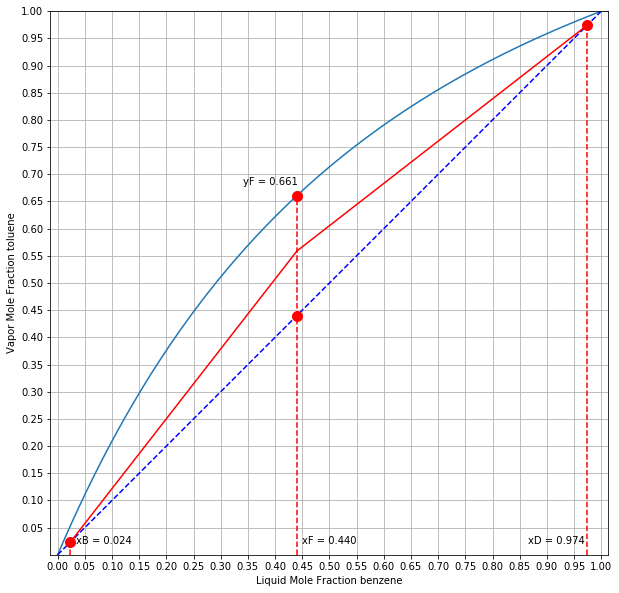

In [52]:
plt.figure(figsize=(10,10))
plt.plot([x(T) for T in T],[y(T) for T in T])
plt.plot([0,1],[0,1],'b--')
plt.axis('equal')
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(0.05,1.0,20))

plt.xlabel('Liquid Mole Fraction {:s}'.format(A))
plt.ylabel('Vapor Mole Fraction {:s}'.format(B))

plt.plot([xD,xD], [0,xD], 'r--')
plt.plot(xD,xD, 'ro', ms=10)
plt.text(xD-0.11, 0.02, 'xD = {:0.3f}'.format(float(xD)))

plt.plot([xF,xF,xF],[0,xF,yF],'r--')
plt.plot([xF,xF],[xF,yF],'ro',ms=10)
plt.text(xF+0.01,0.02,'xF = {:0.3f}'.format(float(xF)))
plt.text(xF-0.1,yF+0.02,'yF = {:0.3f}'.format(float(yF)));

plt.plot([xB,xB], [0,xB], 'r--')
plt.plot(xB,xB, 'ro', ms=10)
plt.text(xB+0.01, 0.02, 'xB = {:0.3f}'.format(float(xB)))

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid();

plt.plot([xD,xF],[xD,zF],'r-')
plt.plot([xB,xF],[xB,zF],'r-');

## Rectangular steps = number of ideal plates

The next step is to draw the rectangular steps between the two operating lines and the equilibrium curve to determine the number of ideal plates.

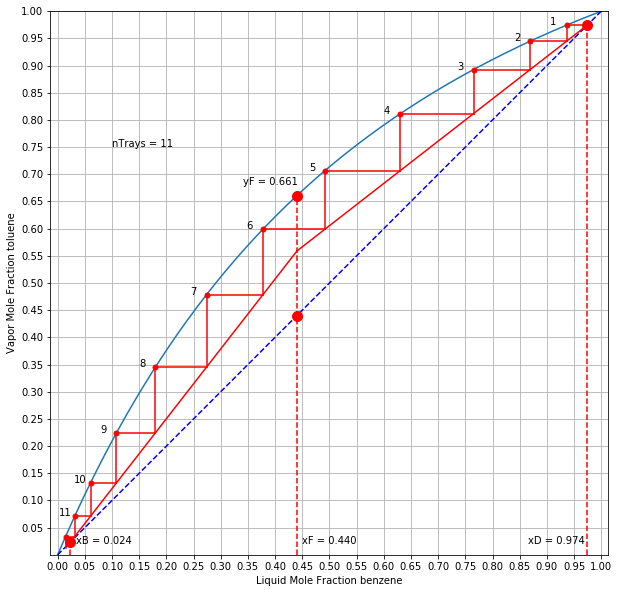

In [58]:
plt.figure(figsize=(10,10))
plt.plot([x(T) for T in T],[y(T) for T in T])
plt.plot([0,1],[0,1],'b--')
plt.axis('equal')
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(0.05,1.0,20))

plt.xlabel('Liquid Mole Fraction {:s}'.format(A))
plt.ylabel('Vapor Mole Fraction {:s}'.format(B))

plt.plot([xD,xD], [0,xD], 'r--')
plt.plot(xD,xD, 'ro', ms=10)
plt.text(xD-0.11, 0.02, 'xD = {:0.3f}'.format(float(xD)))

plt.plot([xF,xF,xF],[0,xF,yF],'r--')
plt.plot([xF,xF],[xF,yF],'ro',ms=10)
plt.text(xF+0.01,0.02,'xF = {:0.3f}'.format(float(xF)))
plt.text(xF-0.1,yF+0.02,'yF = {:0.3f}'.format(float(yF)));

plt.plot([xB,xB], [0,xB], 'r--')
plt.plot(xB,xB, 'ro', ms=10)
plt.text(xB+0.01, 0.02, 'xB = {:0.3f}'.format(float(xB)))

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid();

plt.plot([xD,xF],[xD,zF],'r-')
plt.plot([xB,xF],[xB,zF],'r-')

xP = xD
yP = xD

nTray = 0

while xP > xB:
    nTray += 1
    Tdew = fsolve(lambda T:y(T) - yP, 400)
    xQ = xP
    xP = x(Tdew)
    plt.plot([xQ,xP],[yP,yP],'r')
    plt.plot(xP,yP,'ro',ms=5)
    if xP > xB:
        plt.text(xP-0.03,yP,nTray)
    
    yQ = yP
    yP = min([xD - (R/(R+1))*(xD-xP),xB + ((S+1)/S)*(xP-xB)])
    plt.plot([xP,xP],[yQ,yP],'r')

nTray -= 1 # Account for the reboiler

plt.text(0.1,0.75,'nTrays = {:d}'.format(int(nTray)));

## Feed plate location

Ahhh, but we're not done yet! We didn't determine the location of the feed plate. To do that, we just check to see when $x_P$ goes below $x_F$.

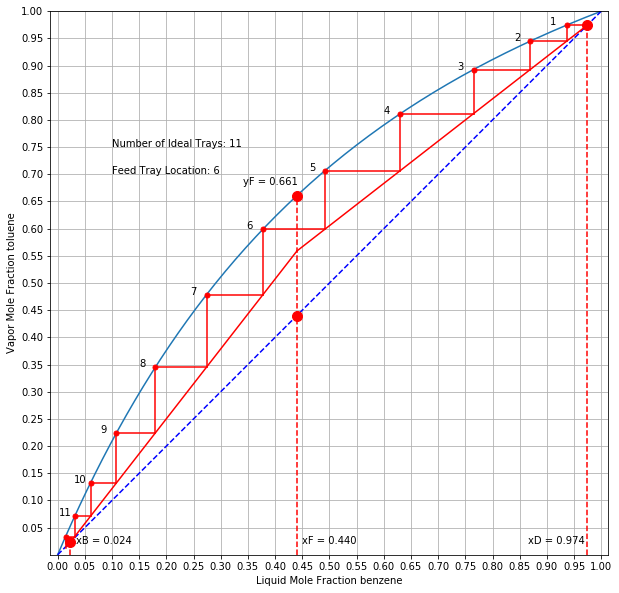

In [66]:
plt.figure(figsize=(10,10))
plt.plot([x(T) for T in T],[y(T) for T in T])
plt.plot([0,1],[0,1],'b--')
plt.axis('equal')
plt.xticks(np.linspace(0,1.0,21))
plt.yticks(np.linspace(0.05,1.0,20))

plt.xlabel('Liquid Mole Fraction {:s}'.format(A))
plt.ylabel('Vapor Mole Fraction {:s}'.format(B))

plt.plot([xD,xD], [0,xD], 'r--')
plt.plot(xD,xD, 'ro', ms=10)
plt.text(xD-0.11, 0.02, 'xD = {:0.3f}'.format(float(xD)))

plt.plot([xF,xF,xF],[0,xF,yF],'r--')
plt.plot([xF,xF],[xF,yF],'ro',ms=10)
plt.text(xF+0.01,0.02,'xF = {:0.3f}'.format(float(xF)))
plt.text(xF-0.1,yF+0.02,'yF = {:0.3f}'.format(float(yF)));

plt.plot([xB,xB], [0,xB], 'r--')
plt.plot(xB,xB, 'ro', ms=10)
plt.text(xB+0.01, 0.02, 'xB = {:0.3f}'.format(float(xB)))

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid();

plt.plot([xD,xF],[xD,zF],'r-')
plt.plot([xB,xF],[xB,zF],'r-')

xP = xD
yP = xD

nTray = 0
located_feed = False
fTray = None

while xP > xB:
    nTray += 1
    Tdew = fsolve(lambda T:y(T) - yP, 400)
    xQ = xP
    xP = x(Tdew)
    plt.plot([xQ,xP],[yP,yP],'r')
    plt.plot(xP,yP,'ro',ms=5)
    if xP > xB:
        plt.text(xP-0.03,yP,nTray)
    if located_feed is False and xP < xF:
        located_feed = True
        fTray = nTray
    
    yQ = yP
    yP = min([xD - (R/(R+1))*(xD-xP),xB + ((S+1)/S)*(xP-xB)])
    plt.plot([xP,xP],[yQ,yP],'r')

nTray -= 1

plt.text(0.1,0.75,'Number of Ideal Trays: {:d}'.format(int(nTray)))
plt.text(0.1,0.70,'Feed Tray Location: {:d}'.format(int(fTray)));